# Unsupervised learning & clustering

In [398]:
import os
import sys
import datetime
import numpy as np
import pandas as pd
from tabulate import tabulate

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import plotly.express as px

from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from IPython.display import display

### Just some matplotlib and seaborn parameter tuning

In [2]:
data = './data/'
out = './out/'
figsave_format = 'png'
figsave_dpi = 200

axistitlesize = 20
axisticksize = 17
axislabelsize = 26
axislegendsize = 23
axistextsize = 20
axiscbarfontsize = 15

# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

mpl.rcParams.update({'figure.autolayout': False})

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

# Colorpalettes, colormaps, etc.
sns.set_palette(palette='rocket')

## 1. Reading data
The woldbank_development_2015.csv (can be found in the same folder with this notebook) file contains the World Development Indicators for the 2015 year, downloaded from [The World Bank's webpage](https://databank.worldbank.org/source/world-development-indicators#).


 - Look at the data in any text editor. Build up an overall sense how the data is built up and how is the missing values are represented.
 - Read the file into a pandas dataframe and tell pandas which special pattern means if a value is missing. 
 - The data is in a long format. Convert it into a wide format, where each row is a single country and the columns are the measured features, the Series Codes (eg the first column is 'EG.CFT.ACCS.ZS', the second is 'EG.ELC.ACCS.ZS'. Order of the columns does not matter)!
 - Keep only those rows, which represents counties and NOT regions. Luckily they are well separated in the order they occur!
 - Convert the features to numeric format, which will be needed for modeling!

### 1./a. Load in dataset

In [3]:
os.listdir(data)

['.ipynb_checkpoints', 'woldbank_development_2015.csv']

In [4]:
df = pd.read_csv(data + 'woldbank_development_2015.csv', sep=',')

In [5]:
display(df.head(n=10))
display(df.tail(n=10))

,Country Name,Country Code,Series Name,Series Code,2015 [YR2015]
0,Afghanistan,AFG,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,30.1
1,Afghanistan,AFG,Access to electricity (% of population),EG.ELC.ACCS.ZS,71.5
2,Afghanistan,AFG,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,64.573353938483
3,Afghanistan,AFG,"Access to electricity, urban (% of urban popul...",EG.ELC.ACCS.UR.ZS,92.5
4,Afghanistan,AFG,Account ownership at a financial institution o...,FX.OWN.TOTL.ZS,..
5,Afghanistan,AFG,Account ownership at a financial institution o...,FX.OWN.TOTL.FE.ZS,..
6,Afghanistan,AFG,Account ownership at a financial institution o...,FX.OWN.TOTL.MA.ZS,..
7,Afghanistan,AFG,Account ownership at a financial institution o...,FX.OWN.TOTL.OL.ZS,..
8,Afghanistan,AFG,Account ownership at a financial institution o...,FX.OWN.TOTL.40.ZS,..
9,Afghanistan,AFG,Account ownership at a financial institution o...,FX.OWN.TOTL.PL.ZS,..


,Country Name,Country Code,Series Name,Series Code,2015 [YR2015]
379363,World,WLD,Women who believe a husband is justified in be...,SG.VAW.NEGL.ZS,..
379364,World,WLD,Women who believe a husband is justified in be...,SG.VAW.REFU.ZS,..
379365,World,WLD,Women who were first married by age 15 (% of w...,SP.M15.2024.FE.ZS,..
379366,World,WLD,Women who were first married by age 18 (% of w...,SP.M18.2024.FE.ZS,..
379367,World,WLD,Women's share of population ages 15+ living wi...,SH.DYN.AIDS.FE.ZS,52.9
379368,NaN,NaN,NaN,NaN,NaN
379369,NaN,NaN,NaN,NaN,NaN
379370,NaN,NaN,NaN,NaN,NaN
379371,Data from database: World Development Indicators,NaN,NaN,NaN,NaN
379372,Last Updated: 09/08/2020,NaN,NaN,NaN,NaN


The last two columns in the dataset are just appended information to the table, and could be left out from the analysis. The three lines preceding them are simply separating these two lines from the actual dataset, so they could be also left out. In summary, we can safely cut off the last 5 rows from the end of the table as they are not part of the data.

In [6]:
df = df.iloc[:-5]

### 1./b. Explore columns and NaN values in the dataset

#### Number of missing values

In [7]:
# Create a mask to analyze missing entries easier
nan_mask = df.isna()

In [8]:
nan_count = nan_mask.sum()

In [9]:
print('Count of missing values:\n' +
      '========================')
print(tabulate([[c, nan_count[c]] for c in nan_count.index], headers=['Feature', 'Count of NaNs']))

Count of missing values:
Feature          Count of NaNs
-------------  ---------------
Country Name                 0
Country Code                 0
Series Name                  0
Series Code                  0
2015 [YR2015]                0


#### Corrected number of missing values

Very important to notice, there are lot of entries in the column `2015 [YR2015]`, which are simply denoted by `..`. These should be considered to be NaN values, but the `pandas.DataFrame.isna()` method won't detect them as such. We need to delete these manually to "replace" them with "true" NaN values.

In [10]:
# Replace '..' with NaN
df = df.replace({'..' : float('nan')})

In [11]:
display(df.head(n=10))
display(df.tail(n=10))

,Country Name,Country Code,Series Name,Series Code,2015 [YR2015]
0,Afghanistan,AFG,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,30.1
1,Afghanistan,AFG,Access to electricity (% of population),EG.ELC.ACCS.ZS,71.5
2,Afghanistan,AFG,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,64.573353938483
3,Afghanistan,AFG,"Access to electricity, urban (% of urban popul...",EG.ELC.ACCS.UR.ZS,92.5
4,Afghanistan,AFG,Account ownership at a financial institution o...,FX.OWN.TOTL.ZS,NaN
5,Afghanistan,AFG,Account ownership at a financial institution o...,FX.OWN.TOTL.FE.ZS,NaN
6,Afghanistan,AFG,Account ownership at a financial institution o...,FX.OWN.TOTL.MA.ZS,NaN
7,Afghanistan,AFG,Account ownership at a financial institution o...,FX.OWN.TOTL.OL.ZS,NaN
8,Afghanistan,AFG,Account ownership at a financial institution o...,FX.OWN.TOTL.40.ZS,NaN
9,Afghanistan,AFG,Account ownership at a financial institution o...,FX.OWN.TOTL.PL.ZS,NaN


,Country Name,Country Code,Series Name,Series Code,2015 [YR2015]
379358,World,WLD,Women participating in the three decisions (ow...,SG.DMK.ALLD.FN.ZS,NaN
379359,World,WLD,Women who believe a husband is justified in be...,SG.VAW.REAS.ZS,NaN
379360,World,WLD,Women who believe a husband is justified in be...,SG.VAW.ARGU.ZS,NaN
379361,World,WLD,Women who believe a husband is justified in be...,SG.VAW.BURN.ZS,NaN
379362,World,WLD,Women who believe a husband is justified in be...,SG.VAW.GOES.ZS,NaN
379363,World,WLD,Women who believe a husband is justified in be...,SG.VAW.NEGL.ZS,NaN
379364,World,WLD,Women who believe a husband is justified in be...,SG.VAW.REFU.ZS,NaN
379365,World,WLD,Women who were first married by age 15 (% of w...,SP.M15.2024.FE.ZS,NaN
379366,World,WLD,Women who were first married by age 18 (% of w...,SP.M18.2024.FE.ZS,NaN
379367,World,WLD,Women's share of population ages 15+ living wi...,SH.DYN.AIDS.FE.ZS,52.9


In [12]:
# Create a mask to analyze missing entries easier
nan_mask = df.isna()

In [13]:
nan_count = nan_mask.sum()

In [14]:
print('Count of missing values:\n' +
      '========================')
print(tabulate([[c, nan_count[c]] for c in nan_count.index], headers=['Feature', 'Count of NaNs']))

Count of missing values:
Feature          Count of NaNs
-------------  ---------------
Country Name                 0
Country Code                 0
Series Name                  0
Series Code                  0
2015 [YR2015]           172946


### 1./c. Drop regions

In [15]:
# Collect name of countries/regions in order of their occurences in the DataFrame
countries_regions = []
for c in df['Country Name']:
    if c not in countries_regions:
        countries_regions.append(c)

If we look at the order of countries in the `countries_regions` list we see, that countries in alphabetic order are folloed by regions in also alphabetic order. Since Zimbabwe is the last country in the alphabet by its name, we should drop every row in the DataFrame, which come after the last entry of `Zimbabwe`.

In [16]:
# Find Zimbabwe in the `countries_regions` list and drop everything after that
countries = countries_regions[:countries_regions.index('Zimbabwe') + 1]
# Drop region data from the DataFrame
df_c = df[df['Country Name'].isin(countries)]
print('Dropped number of regions : {0}'.format(len(countries_regions) - len(countries)), file=sys.stderr)
print('Dropped number of rows : {0}'.format(df.shape[0] - df_c.shape[0]), file=sys.stderr)

Dropped number of regions : 47
Dropped number of rows : 67539


### 1./d. Convert long to wide format

Since we truncate the dataset by fitting countries into a single line, we have to drop a column with unique entries. Why? The new wide format would look like similar to this:

| Index    | Country Name | Country Code | EG.CFT.ACCS.ZS | EG.ELC.ACCS.ZS | $\dots$  |
|:--------:|:------------:|:------------:|:--------------:|:--------------:|:--------:|
| 0        | Afghanistan  | AFG          | $30.1$         | $71.5$         | $\dots$  |
| 1        | Albania      | ALB          | $75.37$        | $100$          | $\dots$  |
| 2        | Algeria      | DZA          | $92.7$         | $99.931...$    | $\dots$  |
| $\vdots$ | $\vdots$     | $\vdots$     | $\vdots$       | $\vdots$       | $\ddots$ |

This format is however missing the `Series Name` column. To be able to clearly handle the description of each series by attaching it to the series itself in the table, we would require another, a third dimension. Because this is not feasible within the framework of `pandas`, I'm leaving this column out of the dataset. I create another dictionary however, to store this information for later use. Also I might use `Country Name` and the index column, and leave out the `Country Code`s

#### Occurence of series codes

In [17]:
# Collect unique series codes and the number of their occurence in the dataset
sc = np.unique(df_c['Series Code'], return_counts=True)
# Collect the unique occurence counts of series codes in the dataset
# Ideally all series codes should exists for each country, thus this
# function should return with only one unique value
sc_c = np.unique(sc[1], return_counts=True)
print('There are {0} different features for each country.'.format(len(sc[0])))
print('There are {0} different countries exist in the dataset'.format(np.sum(sc_c[0])))
if len(sc_c[0]) == 1:
    print('All features exist for each country (however their values still could be NaN).', file=sys.stderr)
else:
    print('There are features, which only exist for some countries!', file=sys.stderr)

There are 1437 different features for each country.
There are 217 different countries exist in the dataset


All features exist for each country (however their values still could be NaN).


Since all series codes/features have an exsting entry in the dataset for each country, we can proceed to the next step of the current task.

#### Construct the new wide format

In [18]:
# First save the descriptions of each series codes
features = {k : v for (k, v) in zip(df_c['Series Code'], df_c['Series Name'])}

In [19]:
# A very simple pivot would convert the table to the desirable wide format
df_wide = df_c.pivot(index='Country Name', columns='Series Code', values='2015 [YR2015]')

In [20]:
df_wide

Series Code,AG.AGR.TRAC.NO,AG.CON.FERT.PT.ZS,AG.CON.FERT.ZS,AG.LND.AGRI.K2,AG.LND.AGRI.ZS,AG.LND.ARBL.HA,AG.LND.ARBL.HA.PC,AG.LND.ARBL.ZS,AG.LND.CREL.HA,AG.LND.CROP.ZS,...,per_sa_allsa.cov_q4_tot,per_sa_allsa.cov_q5_tot,per_si_allsi.adq_pop_tot,per_si_allsi.ben_q1_tot,per_si_allsi.cov_pop_tot,per_si_allsi.cov_q1_tot,per_si_allsi.cov_q2_tot,per_si_allsi.cov_q3_tot,per_si_allsi.cov_q4_tot,per_si_allsi.cov_q5_tot
Country Name,,,,,,,,,,,,,,,,,,,,,
Afghanistan,NaN,590.067055210879,12.1258209916291,379100,58.0675795729559,7765000,0.225637518977597,11.893821033606,2723762,0.222099684465276,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Albania,NaN,NaN,107.831254406965,11743.0004882813,42.8576660156252,615099.975585938,0.213524259733106,22.4489042184649,142600,2.95620437956204,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Algeria,NaN,10.1179965883369,23.3684976182703,414563.984375,17.4059294622839,7462100.09765625,0.187829626508145,3.13304562952138,2686242,0.419987063152557,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
American Samoa,NaN,NaN,NaN,49.0000009536743,24.5000004768372,3000,0.0537518813158461,15,NaN,9.4999998807907,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Andorra,NaN,NaN,NaN,188.099994659424,40.0212754594519,810.000002384186,0.0103831511246387,1.72340426039189,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Virgin Islands (U.S.),NaN,NaN,NaN,40,11.4285714285714,1000,0.00928418902608857,2.85714285714286,NaN,2.85714285714286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
West Bank and Gaza,NaN,NaN,NaN,2969.20013427734,49.3222613667332,50819.9996948242,0.0119013828495555,8.44186041442262,24315,15.9634548960334,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Yemen, Rep.",NaN,NaN,9.81697948162372,235460,44.597230903271,1248000,0.0470980914743812,2.363770668788,585658,0.564426009053545,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1./d. Convert features to numeric format

I don't really understand what does "coverting features to numeric format" would like to mean here. I'll simply convert all entries/**feature values** into numeric format. Let us first count the number of entries in the data table, which isn't in a numeric format, but in eg. `str`. It could be easily seen, that the number of non-float values are equal to the number of string values in the dataset. This trivially means, all non-numeric entries are indeed simple Python `str`s.

In [21]:
def count_non_float_in_df(df):
    # Convert dataframe into an array of dimension (MxN),
    # where M is the number of features, while N is the number of countries
    df_arr = np.array(df).T
    # Create an array to store str() counts for all feature columns
    df_str_c = np.zeros(df_arr.shape[0])

    # Count number of string values in each feature columns
    for i, f in enumerate(df_arr):
        df_str_c[i] = sum(1 for v in f if type(v) == str)

    return df_str_c

In [22]:
df_wide_str_c = count_non_float_in_df(df=df_wide)

print('Total number of non-float feature values in the dataset : {0}'.format(int(sum(df_wide_str_c))), file=sys.stderr)

Total number of non-float feature values in the dataset : 172410


In [23]:
# Convert all columns to numeric format
for c in df_wide.columns:
    # Convert column 'c' of the DataFrame to numeric format
    df_wide[c] = pd.to_numeric(df_wide[c])

In [24]:
df_wide_str_c = count_non_float_in_df(df=df_wide)

print('Total number of non-float feature values in the dataset (after conversion, should be 0 if successful) : {0}'.format(int(sum(df_wide_str_c))), file=sys.stderr)

Total number of non-float feature values in the dataset (after conversion, should be 0 if successful) : 0


## 2. Data preprocessing and inspection

 - Visualize the missing values!
 - Keep only those countries which has less than 700 missing features in the original table and keep features which were missing in less than 20 country in the original table
 - Visualize the missing values again! Now really only a few entries are missing. Impute the missing values with its feature's mean value!
 - How many counties and features do we have left?
 - Read the kept features' descriptions. In the original table the Series Name describe the meaning of the features. What do you think, based only on these information, which counties are the most similar to Hungary? And Norway?  

### 2./a. Visualize the missing values

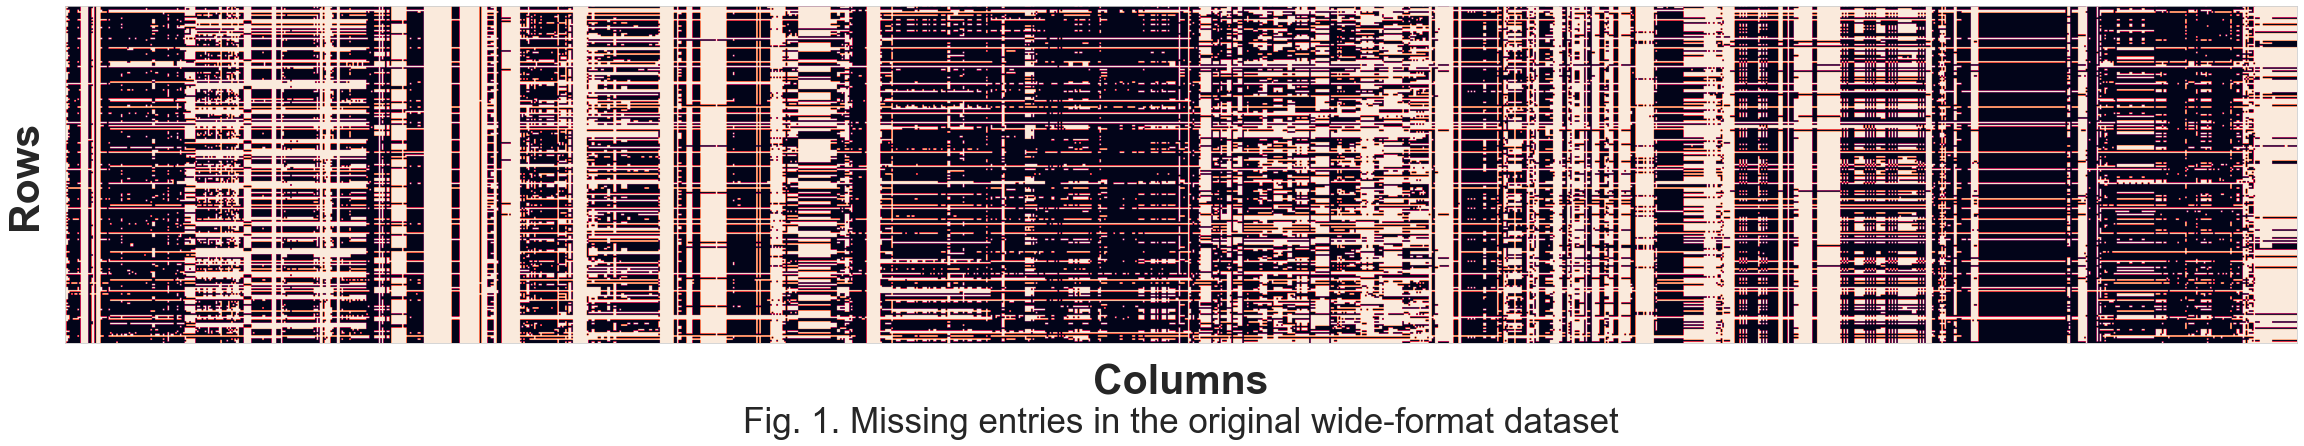

In [25]:
fig, axes = plt.subplots(figsize=(40,40))
axes.set_aspect('equal')

axes.imshow(np.array(df_wide.isna()))

# Remove XY ticks for now
axes.set_xticks([])
axes.set_yticks([])

axes.set_title('Fig. 1. Missing entries in the original wide-format dataset',
               fontsize=axistitlesize+15, y=-0.28)
# Lapelpad needed because of the removed ticks
lp = 20
axes.set_xlabel('Columns', fontsize=axislabelsize+15, fontweight='bold', labelpad=lp)
axes.set_ylabel('Rows', fontsize=axislabelsize+15, fontweight='bold', labelpad=lp)

plt.show()

This in itself is a truly mesmerizing and interesting picture, which I'll definitely set as a cover photo somewhere, but we can also observe a number of important and meaningful things about the dataset on it. It seem so there are columns, which do not store any information whatsover because they're completely filled with NaN entries. I will live with the assumption for now that the "missingness" of entires itself do not contain any useful information for this homework, and I'll simply delete them from the dataset.

In [26]:
# Drop only those columns, which have absolutely none number values
df_wide_dn = df_wide.dropna(axis='columns', thresh=1)
print('Number of dropped columns : {0}'.format(df_wide.columns.size - df_wide_dn.columns.size), file=sys.stderr)
print('Number of remaining columns : {0}'.format(df_wide_dn.columns.size), file=sys.stderr)

Number of dropped columns : 113
Number of remaining columns : 1324


In [27]:
df_wide_dn

Series Code,AG.CON.FERT.PT.ZS,AG.CON.FERT.ZS,AG.LND.AGRI.K2,AG.LND.AGRI.ZS,AG.LND.ARBL.HA,AG.LND.ARBL.HA.PC,AG.LND.ARBL.ZS,AG.LND.CREL.HA,AG.LND.CROP.ZS,AG.LND.FRST.K2,...,per_sa_allsa.cov_q4_tot,per_sa_allsa.cov_q5_tot,per_si_allsi.adq_pop_tot,per_si_allsi.ben_q1_tot,per_si_allsi.cov_pop_tot,per_si_allsi.cov_q1_tot,per_si_allsi.cov_q2_tot,per_si_allsi.cov_q3_tot,per_si_allsi.cov_q4_tot,per_si_allsi.cov_q5_tot
Country Name,,,,,,,,,,,,,,,,,,,,,
Afghanistan,590.067055,12.125821,379100.000000,58.067580,7.765000e+06,0.225638,11.893821,2723762.0,0.222100,13500.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Albania,NaN,107.831254,11743.000488,42.857666,6.151000e+05,0.213524,22.448904,142600.0,2.956204,7715.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Algeria,10.117997,23.368498,414563.984375,17.405929,7.462100e+06,0.187830,3.133046,2686242.0,0.419987,19560.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
American Samoa,NaN,NaN,49.000001,24.500000,3.000000e+03,0.053752,15.000000,NaN,9.500000,175.400009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Andorra,NaN,NaN,188.099995,40.021275,8.100000e+02,0.010383,1.723404,NaN,NaN,160.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Virgin Islands (U.S.),NaN,NaN,40.000000,11.428571,1.000000e+03,0.009284,2.857143,NaN,2.857143,176.000004,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
West Bank and Gaza,NaN,NaN,2969.200134,49.322261,5.082000e+04,0.011901,8.441860,24315.0,15.963455,91.700001,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Yemen, Rep.",NaN,9.816979,235460.000000,44.597231,1.248000e+06,0.047098,2.363771,585658.0,0.564426,5490.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


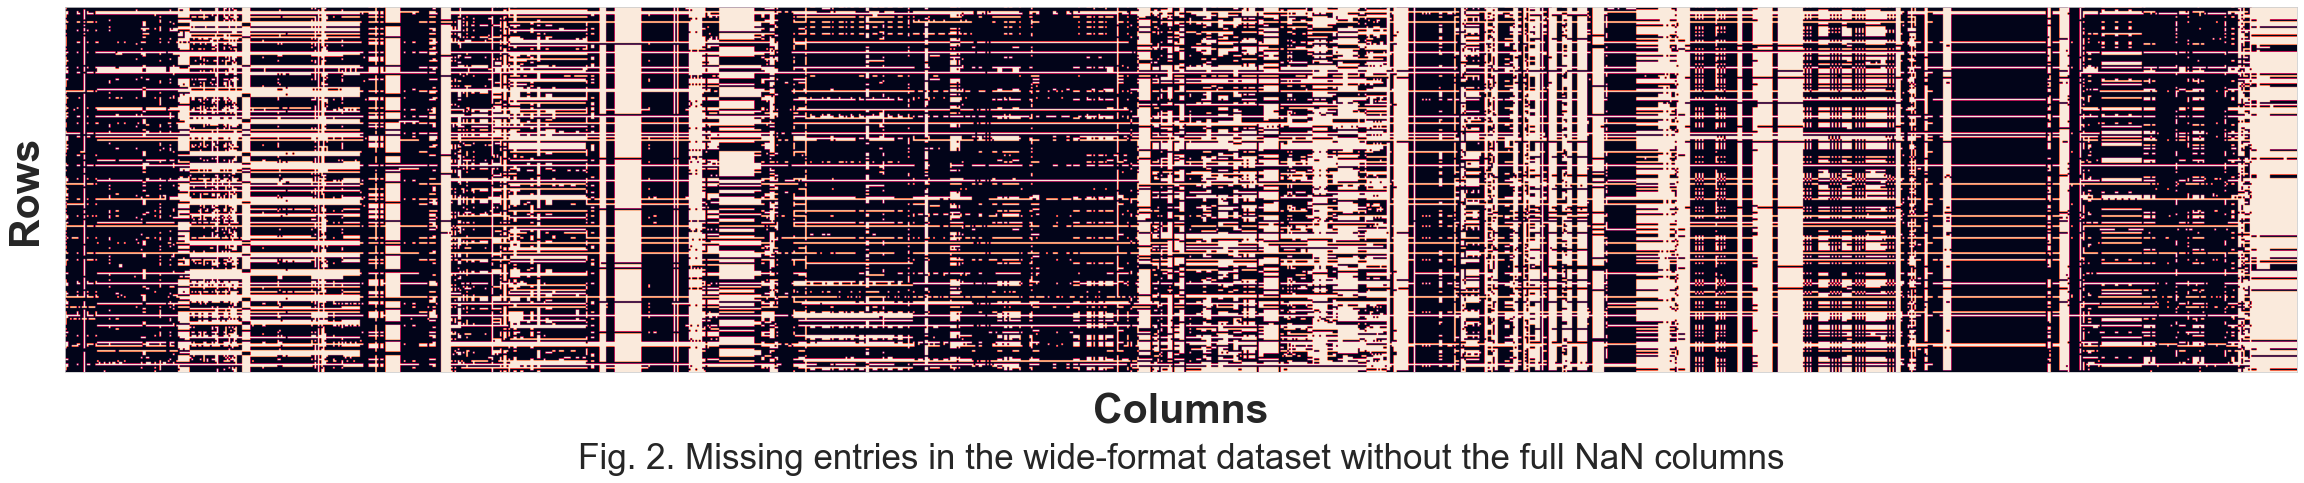

In [28]:
fig, axes = plt.subplots(figsize=(40,40))
axes.set_aspect('equal')

axes.imshow(np.array(df_wide_dn.isna()))

# Remove XY ticks for now
axes.set_xticks([])
axes.set_yticks([])

axes.set_title('Fig. 2. Missing entries in the wide-format dataset without the full NaN columns',
               fontsize=axistitlesize+15, y=-0.28)
# Lapelpad needed because of the removed ticks
lp = 20
axes.set_xlabel('Columns', fontsize=axislabelsize+15, fontweight='bold', labelpad=lp)
axes.set_ylabel('Rows', fontsize=axislabelsize+15, fontweight='bold', labelpad=lp)

plt.show()

### 2./b. Drop out countries with lot of missing values

Since there are $1437$ series as we've seen in the first task, we need to drop countries with at least $737$ existing entries.

In [29]:
# Drop only those columns, which have absolutely none number values
df_w = df_wide_dn.dropna(axis='index', thresh=737)
print('Number of dropped countries : {0}'.format(df_wide_dn.index.size - df_w.index.size), file=sys.stderr)
print('Number of remaining countries : {0}'.format(df_w.index.size), file=sys.stderr)

Number of dropped countries : 54
Number of remaining countries : 163


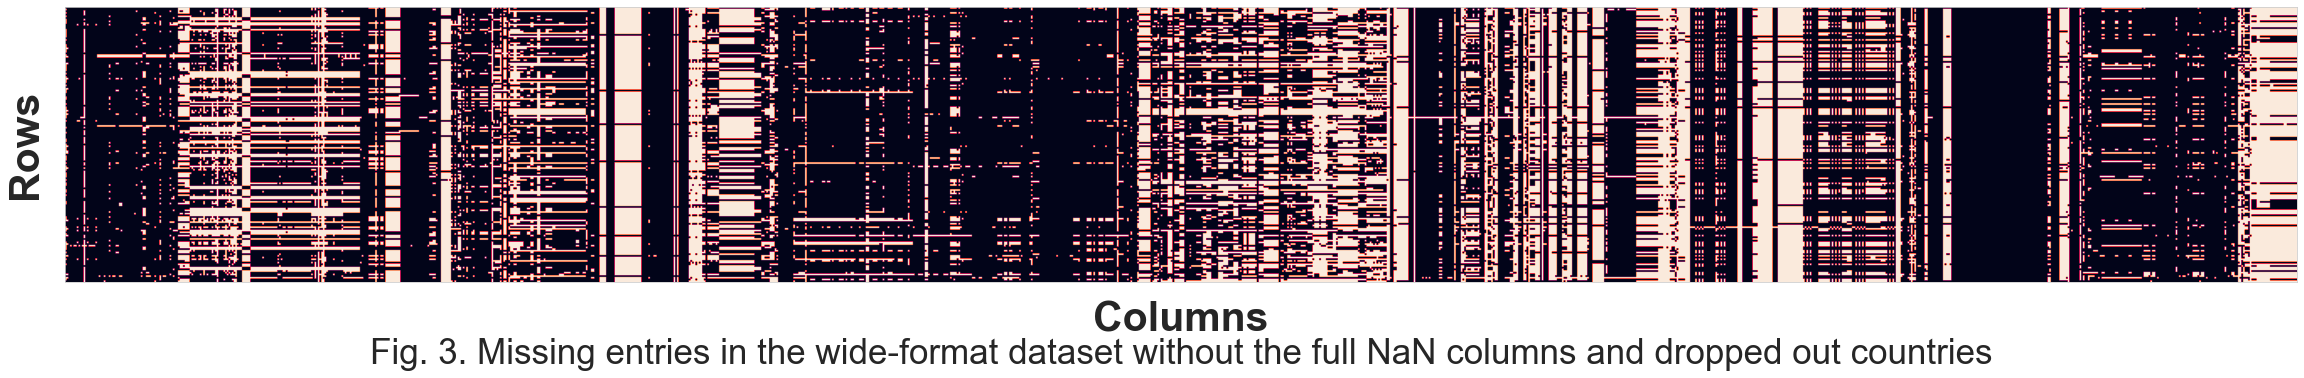

In [30]:
fig, axes = plt.subplots(figsize=(40,40))
axes.set_aspect('equal')

axes.imshow(np.array(df_w.isna()))

# Remove XY ticks for now
axes.set_xticks([])
axes.set_yticks([])

axes.set_title('Fig. 3. Missing entries in the wide-format dataset without the full NaN columns and dropped out countries',
               fontsize=axistitlesize+15, y=-0.32)
# Lapelpad needed because of the removed ticks
lp = 20
axes.set_xlabel('Columns', fontsize=axislabelsize+15, fontweight='bold', labelpad=lp)
axes.set_ylabel('Rows', fontsize=axislabelsize+15, fontweight='bold', labelpad=lp)

plt.show()

### 2./c. Fill NaN entries


Filling all missings entries by the mean of its feature values as asked in the description.

In [31]:
# NOTE: The new variable has an extra `f` at its end
df_wf = df_w.fillna(df_w.mean())

### 2./d. Which country is the closest to Hungary? And Norway?

Based on the current dataset `df_wf` it is not completely trivial to answer this question. For example we can define a score, which could measure the "distance" of each country from Hungary and Norway. This score could be interpeted as some function of the differences between features of two separate countries. In this framework we should find the country corresponding to the global extrema of this scoring function (eg. a minima in the case of the distance interpretation). I'll simply use the MSE of features compared to Hungary/Norway as a scoring function for this sub-task.

#### Create anf calculate score for a country

In [32]:
MSE = {}

In [35]:
def add_country_2_MSE(MSE, ref):

    # Calculate MSE values
    mse_list = []
    for c in df_wf.index:
        mse_list.append(mean_squared_error(df_wf.loc[ref], df_wf.loc[c]))
    # Normalize dataset
    mse_list = np.array(mse_list) / np.max(mse_list)
    MSE[ref] = {c : v for (c, v) in zip(df_wf.index, mse_list)}

    return MSE

In [36]:
MSE = add_country_2_MSE(MSE, ref='Hungary')
MSE = add_country_2_MSE(MSE, ref='Norway')

#### Visualize the scores for Hungary

In [66]:
def plot_MSE_country(country):

    # Sort countries by score values
    x = list(df_wf.index)
    y = list(MSE[country].values())
    y, x = (list(z) for z in zip(*sorted(zip(y, x))))

    # Documentation was very useful @:
    # https://plotly.com/python/bar-charts/
    fig = px.bar(y=x[::-1], x=y[::-1], text=y[::-1],
                 color=y[::-1],
                 log_x=True,
                 title='Fig. 4. MSE of features compared to Hungary',
                 labels={
                     'y': 'Countries in ascending order by score',
                     'x': 'Log of score values',
                 },
                 orientation='h', width=1300, height=2600)
    fig.update_traces(hovertemplate='Country : %{y}</br>MSE : %{x:.3e}',
                      texttemplate='%{text:.3e}',
                      textposition='outside')
    fig.update_layout(coloraxis_colorbar=dict(
                            dtick=0.05,
                            tickfont=dict(
                                family='Arial',
                                color='black',
                                size=22)
                            ),
                      font=dict(
                          family='Arial',
                          size=12,
                          color='black'
                            ),
                      uniformtext_minsize=4,
                      uniformtext_mode='hide'
                     )
    fig.show()

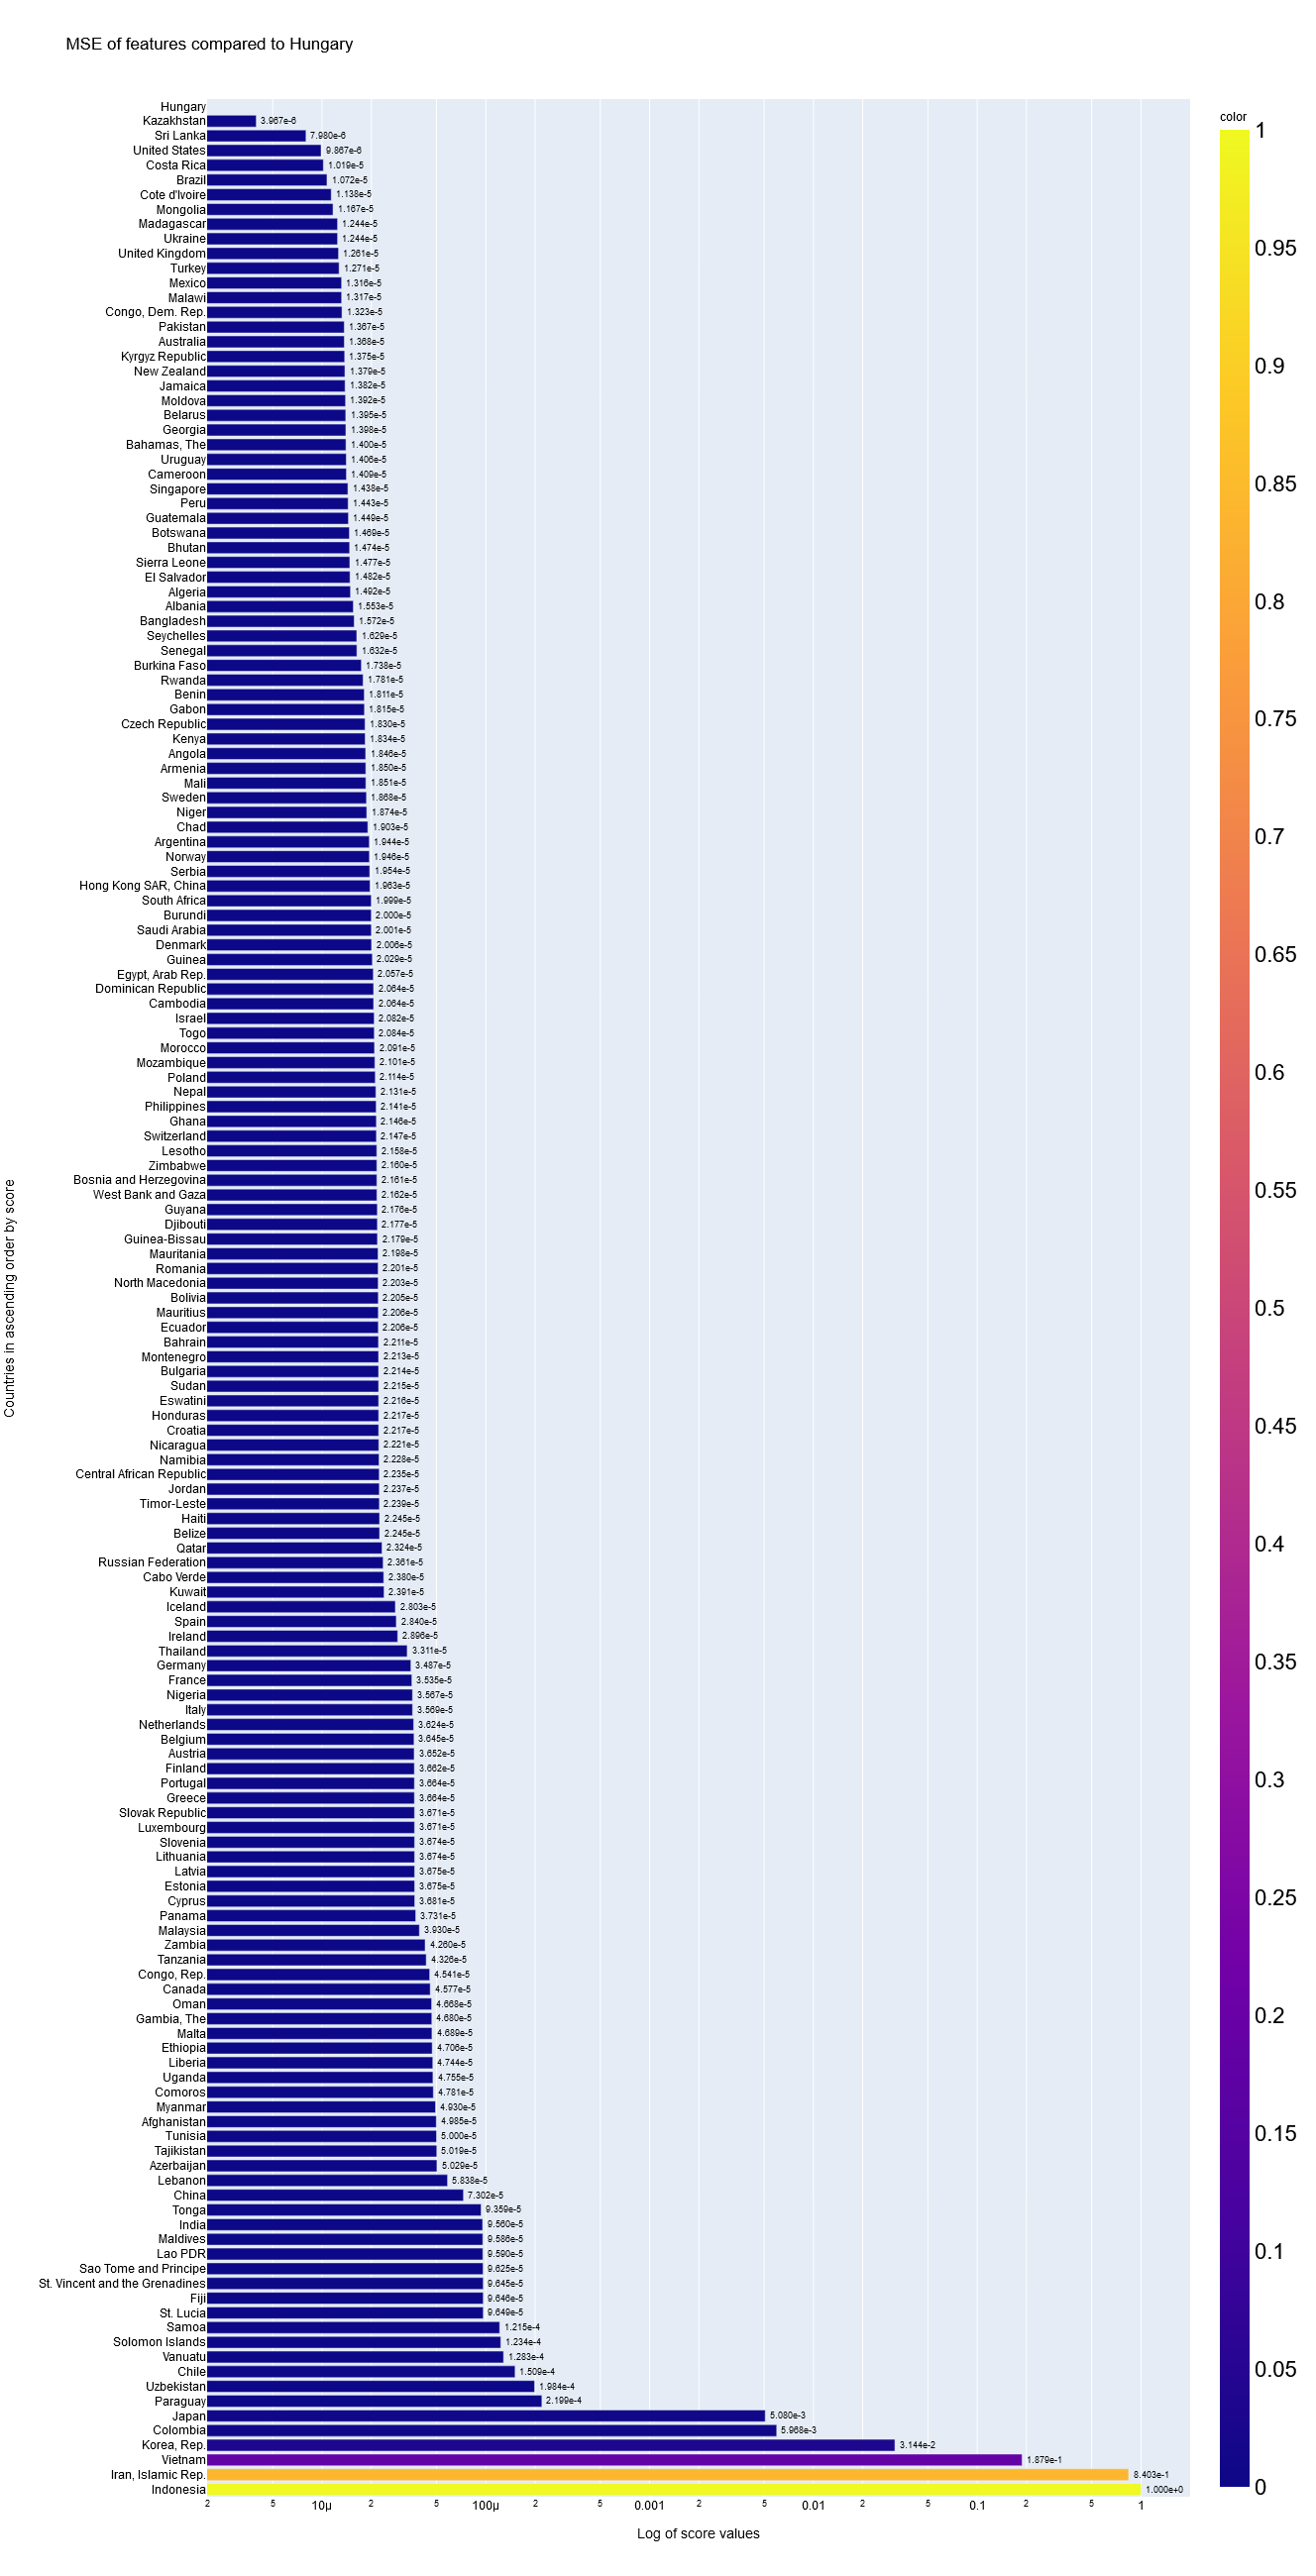

In [68]:
plot_MSE_country(country='Hungary')

#### Discussion

According to a simple MSE score, Kazahstan is the closest one to our country in economic aspects, which is a bit unsettling information. The closest country to Norway is Denmark, which is quite more comforting to Norway people.

In [78]:
def closest_country_by_MSE(ref):
    
    x = list(df_wf.index)
    y = list(MSE[ref].values())
    y, x = (list(z) for z in zip(*sorted(zip(y, x))))
    
    print('The "closest" country to [{0}] by this scoring function is [{1}].'.format(ref, x[::-1][-2]))

In [80]:
closest_country_by_MSE(ref='Hungary')
closest_country_by_MSE(ref='Norway')

The "closest" country to [Hungary] by this scoring function is [Kazakhstan].
The "closest" country to [Norway] by this scoring function is [Denmark].


## 3. PCA
 - Perform PCA with 3 principal components on the filtered, imputed data (from now on, data refers to the filtered, imputed dataset)
 - Plot the three embedded 2D combination next to each other (0 vs 1, 0 vs 2 and 1 vs 2)
 - It seems that the embedding is really dominated by a single direction. Normalize the data (each feature should have zero mean and unit variance after normalization) and re-do the PCA and the plotting (do not delete the previous plots, just make new ones).

### 3./a. Calculate and visualize PCA

I actually salvaged these old PCA calc. and plotting functions of mine from one of my projects from last year.

In [408]:
def PCA(X, n_components=3, norm=False):
    
    # Normalize the data to zero mean and unit variance
    if norm:
        # Instantiate
        scaler = StandardScaler()
        # Compute the mean and standard dev. and scale the dataset `X`
        X = scaler.fit_transform(X)
    
    # Permorm the PCA and return the newly created dataset
    pca = decomposition.PCA(n_components=n_components)
    pca.fit(X)
    X_pca = pca.transform(X)
    
    # Ex-variance to measure impact of PCA features
    ex_var = np.var(X_pca, axis=0)
    ex_var_ratio = ex_var/np.sum(ex_var)
    
    return pca, X_pca, ex_var_ratio

In [420]:
def plot_pca_scatter(X_pca, input_title=None, zoom=10):
    
    nrows = 2
    ncols = 3
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*10, nrows*10))
    
    color = 'tab:blue'
    alpha = 0.6
    
    # Which pair of PCs plotted in different columns on the plot
    pairs = [(0, 1), (1, 2), (0, 2)]
    labels = [('First', 'Second'), ('Second', 'Third'), ('First', 'Third')]

    for j in range(nrows):
        for i in range(ncols):
            ax = axes[j][i]
            
            X = X_pca[:, pairs[i][0]]
            Y = X_pca[:, pairs[i][1]]
            ax.scatter(X, Y,
                       color=color, alpha=alpha)
            
            # Some string magic to hide offset text and write scale on the axis labels
            # 1. Turn off offset
            plt.setp(ax.get_xaxis().get_offset_text(), visible=False)
            plt.setp(ax.get_yaxis().get_offset_text(), visible=False)
            # 2. Get scale of axes
            x_lim = ax.get_xlim()
            y_lim = ax.get_ylim()
            # 3. Select greater limit in magnitude, force it to scientific notation
            # and trim down the exponent
            x_max = np.max(np.abs(x_lim))
            y_max = np.max(np.abs(y_lim))
            xy_max = np.max((x_max, y_max))
            
            # Do nothing special in the first row
            if j == 0:
                x_offset = int(('%E' % x_max).split('E')[-1])
                y_offset = int(('%E' % y_max).split('E')[-1])
            # Zoom on the center of the dataset in the second row
            elif j == 1:
                c = (np.mean(X), np.mean(Y))
                ax.set_xlim(c[0] - xy_max/zoom, c[0] + xy_max/zoom)
                ax.set_ylim(c[1] - xy_max/zoom, c[1] + xy_max/zoom)
                # Scale offsets accordingly to zooming/scalong factor
                x_offset = int(('%E' % xy_max).split('E')[-1]) - int(np.log10(zoom))
                y_offset = int(('%E' % xy_max).split('E')[-1]) - int(np.log10(zoom))
            
            # Format labels and ticks
            ax.set_xlabel('{0} PC [$\\times 10^{{{1}}}$]'.format(labels[i][0], x_offset),
                               fontsize=axislabelsize+6, fontweight='bold')
            ax.set_ylabel('{0} PC [$\\times 10^{{{1}}}$]'.format(labels[i][1], y_offset),
                               fontsize=axislabelsize+6, fontweight='bold')
            ax.tick_params(axis='both', which='major', labelsize=axisticksize+6)
    
    fig.suptitle(input_title,
                 fontsize=axistitlesize+6, y=0.04)
    
    plt.show()

In [421]:
def plot_pca_components(pca, features, n_components, save=False):
    
    fig, axes = plt.subplots(figsize=(22,22))

    pca_basis = pca.components_
    c = axes.matshow(pca_basis,cmap='viridis')
    plt.yticks([i for i in range(n_components)],
               ['{0}. Comp.'.format(i+1) for i in range(n_components)],
               fontsize=axisticksize)
    plt.xticks(range(len(features)), features,
               fontsize=axisticksize, rotation=65, ha='left')
    plt.colorbar(mappable=c, ax=axes)

    for y in range(pca_basis.shape[0]):
        for x in range(pca_basis.shape[1]):
            plt.text(x, y, '{0:.4f}'.format(pca_basis[y, x]),
                     horizontalalignment='center',
                     verticalalignment='center',
                     color='white',
                     fontsize=textsize, fontweight='bold',
                     bbox={'facecolor':np.array([0,0,0,0.3]), 'edgecolor':'none', 'pad':0.5},
                     )
    
    if save:
        plt.savefig(fig_save_out + 'metric/' +
                    current_debug_filename.split('/')[-2] +
                    '_full_dataset_pca_weights_{0}_pc'.format(n_components) +
                    fig_save_format,
                    dpi=fig_save_dpi,
                    bbox_inches='tight')
    plt.show()


#### Unscaled PCA

In [422]:
pca, X_pca, ex_var_ratio = PCA(X=df_wf, n_components=3)
print(ex_var_ratio)
print('Weight if first three PC : {0:.3f}%'.format(ex_var_ratio[:3].sum()*100))

[0.96171682 0.02329362 0.01498956]
Weight if first three PC : 100.000%


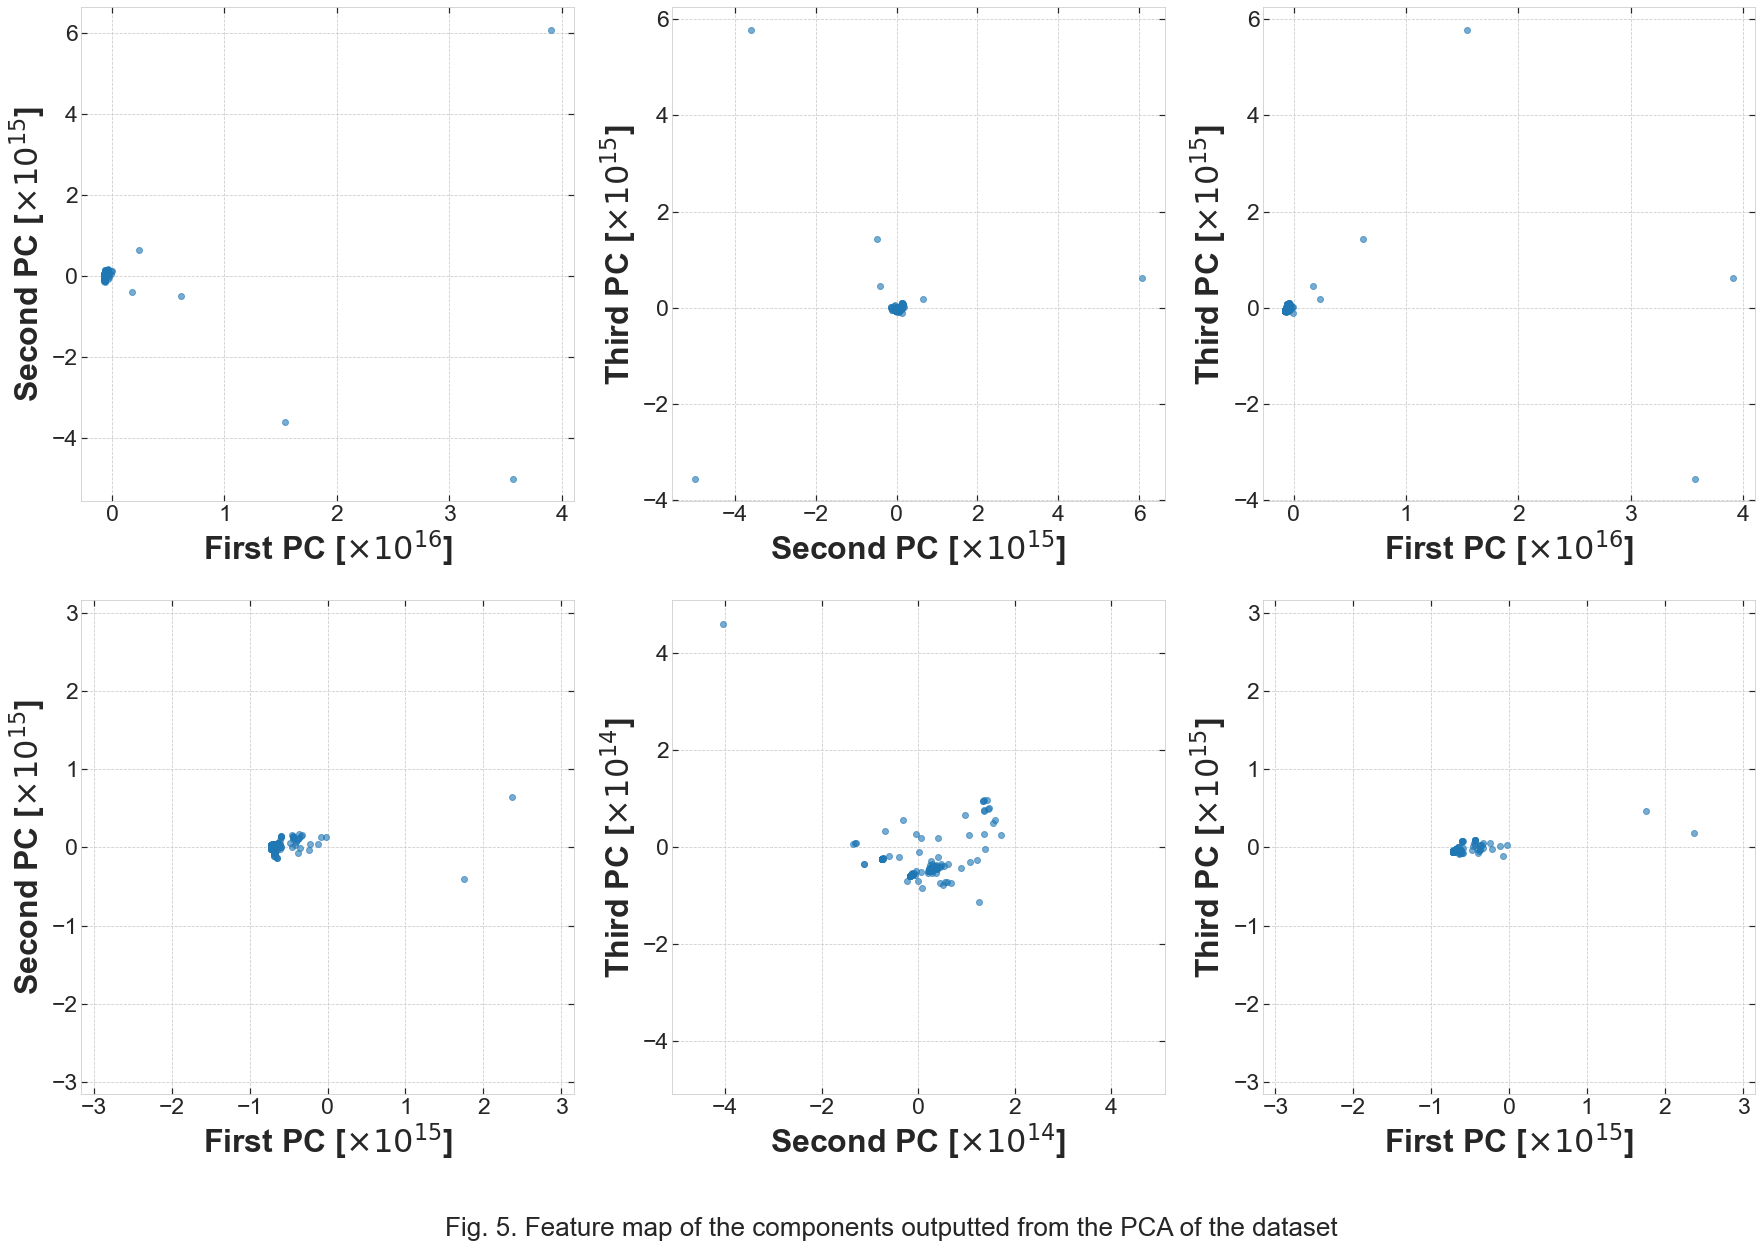

In [423]:
input_title = 'Fig. 5. Feature map of the components outputted from the PCA of the dataset'
plot_pca_scatter(X_pca=X_pca, input_title=input_title, zoom=13)

### 3./b. Normalize the dataset and redo the PCA

#### Scaled PCA

In [425]:
pca, X_pca, ex_var_ratio = PCA(X=df_wf, n_components=3, norm=True)
print(ex_var_ratio)
print('Weight if first three PC : {0:.3f}%'.format(ex_var_ratio[:3].sum()*100))

[0.51043177 0.29566295 0.19390528]
Weight if first three PC : 100.000%


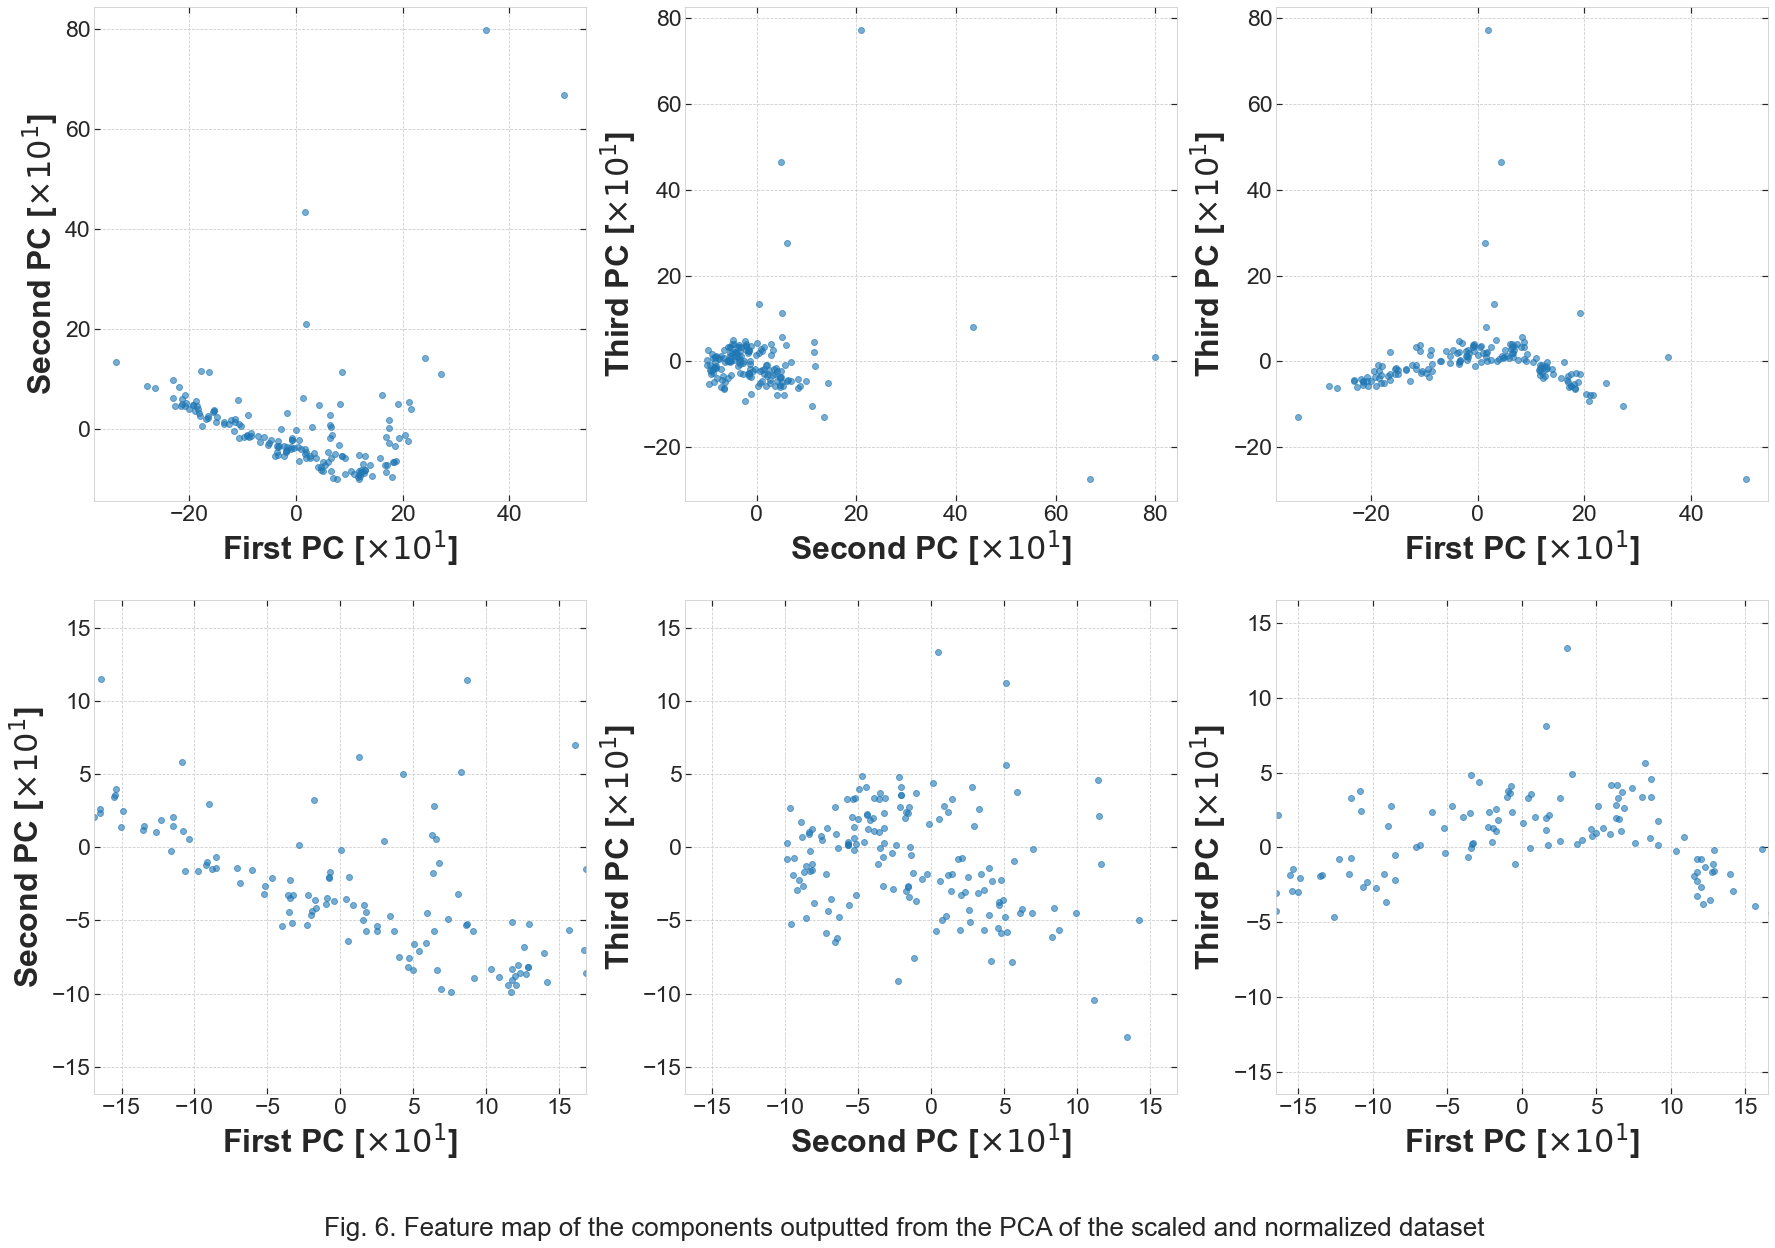

In [426]:
input_title = 'Fig. 6. Feature map of the components outputted from the PCA of the scaled and normalized dataset'
plot_pca_scatter(X_pca=X_pca, input_title=input_title, zoom=5)

## 4. T-SNE
 - Perform T-SNE on the scaled data with 2 components
 - Plot the embeddings results. Add a text label for each point to make it possible to interpret the results. It will not be possible to read all, but try to make it useful, see the attached image as an example!
 - Highlight Hungary and Norway! Which countries are the closest one to Hungary and Norway? 

## 5. Hierarchical clustering

 - Perform hierarchical clustering on the filtered and scaled data (hint: use seaborn **(\*sklearn lol)**)
 - Try to plot in a way that all country's name is visible
 - Write down your impressions that you got from this plot!

In [ ]:
# placeholder for the plot

### Hints:
 - On total you can get 10 points for fully completing all tasks.
 - Decorate your notebook with, questions, explanation etc, make it self contained and understandable!
 - Comments you code when necessary
 - Write functions for repetitive tasks!
 - Use the pandas package for data loading and handling
 - Use matplotlib and seaborn for plotting or bokeh and plotly for interactive investigation
 - Use the scikit learn package for almost everything
 - Use for loops only if it is really necessary!
 - Code sharing is not allowed between student! Sharing code will result in zero points.
 - If you use code found on web, it is OK, but, make its source clear! 